In [1]:
%load_ext autotime

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import glob
import pylab as plt
import json
import matplotlib as mpl
import os

import seaborn as sns
sns.set(style="darkgrid")

time: 601 ms


In [3]:
old_new_dist = pd.read_csv('../../../data/district_relation.csv')
old_new_dist_map = old_new_dist[['DIST2012', 'NEW_DIST_ID_2']].set_index('DIST2012').to_dict()['NEW_DIST_ID_2']
pop_dense = pd.read_csv('../../../data/district_pop_dens_friction.csv')
old_new_dist = old_new_dist.merge(pop_dense, on='DIST2012')

old_new_dist.head()

,Unnamed: 0,CNTRY_NAME_x,ADMIN_NAME_x,CNTRY_CODE_x,IPUM2012_x,DIST2012,PARENT_x,NEW_DIST_ID_2,CNTRY_NAME_y,ADMIN_NAME_y,CNTRY_CODE_y,IPUM2012_y,PARENT_y,mean_pop_dens,total_pop,mean_friction_pop_weighted
0,1,Zimbabwe,Bulawayo Urban,716,21,21,0,1,Zimbabwe,Bulawayo Urban,716,21,0,1096.578765,629436.210860,0.002247
1,2,Zimbabwe,Buhera,716,1001,101,1,3,Zimbabwe,Buhera,716,1001,1,40.271155,266876.945520,0.009854
2,3,Zimbabwe,Chimanimani,716,1002,102,1,4,Zimbabwe,Chimanimani,716,1002,1,36.526321,151584.230765,0.015841
3,4,Zimbabwe,Chipinge Rural,716,1003,103,1,5,Zimbabwe,Chipinge Rural,716,1003,1,51.065586,332947.622011,0.012035
4,5,Zimbabwe,Makoni,716,1004,104,1,6,Zimbabwe,Makoni,716,1004,1,31.112857,299616.813787,0.010436


time: 26.7 ms


In [4]:
import geopandas as gpd

# p = gpd.read_file('../data/geo2_zw2012.shp')
shape = p = gpd.read_file('../../../data/shapefiles/new_districts/ZWE_adm2.shp')

time: 174 ms


In [5]:
shape['total_population'] = shape['ID_2'].map(old_new_dist.groupby('NEW_DIST_ID_2')['total_pop'].sum())

time: 3.82 ms


# Trajectory by district

In [6]:
from scenario_models import *

time: 7.96 ms


In [7]:
import pickle

time: 325 µs


In [8]:
def get_model_statistics(model, ward_id=None, scale=22):
    model_data = pd.DataFrame(
        {
            'date_infected': model.date_infected,
            'date_start_hospitalized': model.date_start_hospitalized,
            'date_start_critical': model.date_start_critical,
            'date_recovered': model.date_recovered,
            'date_died': model.date_died,
            'ward_id': list(map(lambda x: model.params.WARD_ID_TO_NAME.get(x, x), model.ward_ids)),
            'ward_id_code': model.ward_ids,
            'infected_at_ward_id': list(map(lambda x: model.params.WARD_ID_TO_NAME.get(x, x), model.infected_at_ward_ids)),
            'symptomatic_status': model.infected_symptomatic_status,
            'age': model.age,
            'economic_status_id': list(map(lambda x: model.params.ECON_STAT_ID_TO_NAME.get(x, x), model.economic_status_ids)),
            'economic_status_id_code': model.economic_status_ids,
        }
    )

    model_data['ID_2'] = model_data['ward_id'].str.strip('w_').astype(int)  # .map(old_new_dist_map)

    if ward_id is not None:
        model_data = model_data[model_data['ward_id'] == ward_id]

    return model_data


def get_active_cases(model_data, ref_col, start_col, end_cols, date_start='2020-04-20', date_end='2020-12-30', scale=22):
    hosps = model_data[model_data[start_col] < datetime.max].copy()
    hosps['day_start'] = hosps[start_col].dt.date

    ends = []
    for col in end_cols:
        ends.append(hosps[col][hosps[col] < datetime.max].dt.date)

    hosps['day_end'] = pd.concat(ends)

    ind = pd.period_range(start=date_start, end=date_end, freq='D')
    ind = ind.to_timestamp()

    col_name = start_col.split('_')[-1]
    col_name = f'active_{col_name}'

    active_hospitalizations = pd.DataFrame(columns=[col_name], index=ind).fillna(0)

    active_hosp_range_count = hosps.groupby(['day_start', 'day_end'])[ref_col].count()

    for start, end in active_hosp_range_count.index:
        active_hospitalizations.loc[start:end, col_name] += scale * active_hosp_range_count[(start, end)]

    return active_hospitalizations


def epidemic_statistics(model_data, case_col='date_infected', date_start='2020-04-20', date_end='2020-11-20', scale=22):

#     hospitalized = model_data[model_data['date_start_hospitalized'] < datetime.max]
#     q = hospitalized['date_start_hospitalized'].dt.date.value_counts().sort_index()

    hospitalized = model_data[model_data[case_col] < datetime.max].copy()
    q = hospitalized[case_col].dt.date.value_counts().sort_index()

    q = scale * q

    ind = pd.period_range(start=date_start, end=date_end, freq='D')
    ind = ind.to_timestamp()

    return q[ind].fillna(0).cumsum()

time: 4.21 ms


In [10]:
scale = 11

scenario_files = {
#     'UnmitigatedScenario': 'Unmitigated w/o hand\nwashing considerations',
    'HandWashingRiskScenario': 'Unmitigated w/ hand\nwashing considerations',
#     'HandWashingRiskImproved1Scenario': 'Unmitigated w/ improved\nhand washing',
#     'HandWashingRiskImproved2Scenario': 'Unmitigated w/ extreme hand\nwashing',
#     'BlockGreatestMobilityScenario': 'Selective Blocking',
#     'LockdownGreatestMobilityScenario': 'Selective lockdown',
#     'OpenSchoolsScenario': 'Continued lockdown - open schools',
#     'OpenManufacturingScenario': 'Continued lockdown - open manufacturing',
#     'OpenMiningScenario': 'Continued lockdown - open mining',
#     'ContinuedLockdownScenario': 'Continued lockdown',
#     'OpenManufacturingAndSchoolsScenario': 'Continued lockdown - open\nmanufacturing/schools',
#     'InteractionSensitivityScenario': 'Unmitigated - homogeneous interaction',
}


for scenario in scenario_files:
    scenario_code = '_'.join(scenario.split('.')[0].split('_')[2:])
    scenario_code = scenario_files.get(scenario)
    scenario_df = []

    for sim_id, dump_file in enumerate(glob.glob(f'./logs/model_dump_file_{scenario}*R1.9*.pickle')):
        print(f'Loading {dump_file}...')

        try:
            with open(dump_file, 'rb') as fl:
                model = pickle.load(fl)
        except pickle.UnpicklingError:
            continue

        model_df = get_model_statistics(model, scale=scale)
        model_df['sim_id'] = sim_id

        scenario_df.append(model_df)

    scenario_df = pd.concat(scenario_df)

Loading ./logs/model_dump_file_HandWashingRiskScenario_02_R1.9_samp10_seed90.2020-05-14T02:46:15.485634.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_00_R1.9_samp10_seed90.2020-05-14T02:46:15.344926.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_01_R1.9_samp10_seed90.2020-05-14T02:46:15.442602.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_04_R1.9_samp10_seed90.2020-05-14T02:46:15.267039.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_05_R1.9_samp10_seed90.2020-05-14T02:46:15.546502.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_07_R1.9_samp10_seed90.2020-05-14T02:46:15.490580.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_03_R1.9_samp10_seed90.2020-05-14T02:46:15.336737.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_06_R1.9_samp10_seed90.2020-05-14T02:46:15.511568.pickle...
Loading ./logs/model_dump_file_HandWashingRiskScenario_08_R1.9_samp10_seed90.2020-05-14T

In [11]:
len(scenario_df)

13093760

time: 2.52 ms


In [13]:
date_start = '2020-04-20'
date_end = '2020-12-01'
period = 'D'
ind_start = pd.period_range(start=date_start, end=date_end, freq=period)
ind_start

PeriodIndex(['2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
             '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27',
             '2020-04-28', '2020-04-29',
             ...
             '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
             '2020-11-26', '2020-11-27', '2020-11-28', '2020-11-29',
             '2020-11-30', '2020-12-01'],
            dtype='period[D]', length=226, freq='D')

time: 12.7 ms


PeriodIndex(['2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
             '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28',
             '2020-04-29', '2020-04-30',
             ...
             '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-26',
             '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
             '2020-12-01', '2020-12-02'],
            dtype='period[D]', length=226, freq='D')

time: 3.41 ms


In [16]:
pd.Timedelta?

time: 45.3 ms


Init signature: pd.Timedelta(value=<object object at 0x7fe48c5f1ac0>, unit=None, **kwargs)
Docstring:     
Represents a duration, the difference between two dates or times.

Timedelta is the pandas equivalent of python's ``datetime.timedelta``
and is interchangeable with it in most cases.

Parameters
----------
value : Timedelta, timedelta, np.timedelta64, string, or integer
unit : str, optional
    Denote the unit of the input, if input is an integer. Default 'ns'.
    Possible values:
    {'Y', 'M', 'W', 'D', 'days', 'day', 'hours', hour', 'hr', 'h',
    'm', 'minute', 'min', 'minutes', 'T', 'S', 'seconds', 'sec', 'second',
    'ms', 'milliseconds', 'millisecond', 'milli', 'millis', 'L',
    'us', 'microseconds', 'microsecond', 'micro', 'micros', 'U',
    'ns', 'nanoseconds', 'nano', 'nanos', 'nanosecond', 'N'}
**kwargs
    Available kwargs: {days, seconds, microseconds,
    milliseconds, minutes, hours, weeks}.
    Values for construction in compat with datetime.timedelta.
    Numpy

In [18]:
date_start = '2020-04-20'
date_end = '2020-12-01'
period = 'D'
# date_end = scenario_df.date_recovered[scenario_df.date_recovered < datetime.max].max()
# date_end = date_end.strftime('%Y-%m-%d')
if period == 'D':
    ind_start = pd.period_range(start=date_start, end=date_end, freq=period)
    ind_end = ind_start + pd.Timedelta(1, unit=period)
    ind = list(zip(ind_start, ind_end))
else:
    ind = pd.period_range(start=date_start, end=date_end, freq=period)

case_col = 'date_infected'
scenario_data = []

for sim_id in scenario_df.sim_id.unique():
    print(sim_id)
    md = scenario_df[scenario_df.sim_id == sim_id].copy()

    for dist_id in md.ID_2.unique():
        dmd = md[md.ID_2==dist_id].copy()

        for e in ind:
            if period == 'D':
                st, en = e
            elif period == 'W':
                st, en = str(e).split('/')

            if dmd[dmd[case_col] < datetime.max].empty:
                i = 0
            else:
                i = epidemic_statistics(dmd, case_col=case_col, date_start=st, date_end=en, scale=scale).diff().sum()
            scenario_data.append([sim_id, dist_id, st, i])

0
1
2
3
4
5
6
7
8
9
time: 36min 47s


In [19]:
tperiod = 'week' if period == 'W' else 'day'
scenario_data_df = pd.DataFrame(scenario_data, columns=['sim_id', 'ID_2', tperiod, case_col.split('_')[-1]])
unmitigated_scenario_data_df = scenario_data_df.copy()

time: 108 ms


In [20]:
old_new_dist.groupby('NEW_DIST_ID_2')['total_pop'].sum().head()

NEW_DIST_ID_2
1    6.294362e+05
2    2.287502e+06
3    2.668769e+05
4    1.515842e+05
5    3.567675e+05
Name: total_pop, dtype: float64

time: 4.04 ms


In [21]:
spatial_scenario_data_df = scenario_data_df.merge(shape[['ID_2', 'NAME_2']], on='ID_2', how='left')

time: 12.9 ms


In [46]:
inbound_5 = ['Harare', 'Zvimba', 'Goromonzi', 'Bulawayo', 'Masvingo']
outbound_5 = ['Harare', 'Goromonzi', 'Zvimba', 'Bulawayo', 'Masvingo']

top_5_inbound = spatial_scenario_data_df[spatial_scenario_data_df['NAME_2'].isin(inbound_5)].copy()
top_5_outbound = spatial_scenario_data_df[spatial_scenario_data_df['NAME_2'].isin(outbound_5)].copy()

time: 11.5 ms


In [41]:
pp = top_5_inbound[tperiod].loc[0]
pp

Period('2020-04-20', 'D')

time: 1.75 ms


In [49]:
tstamps = top_5_inbound[tperiod].map(lambda x: x.to_timestamp())
top_5_inbound[f'{tperiod}s'] = tstamps
top_5_inbound['district'] = top_5_inbound['NAME_2']

time: 881 ms


In [51]:
import matplotlib.dates as mdates

time: 404 µs


Text(0.5, 1.0, 'Active cases in top 5 districts by movement')

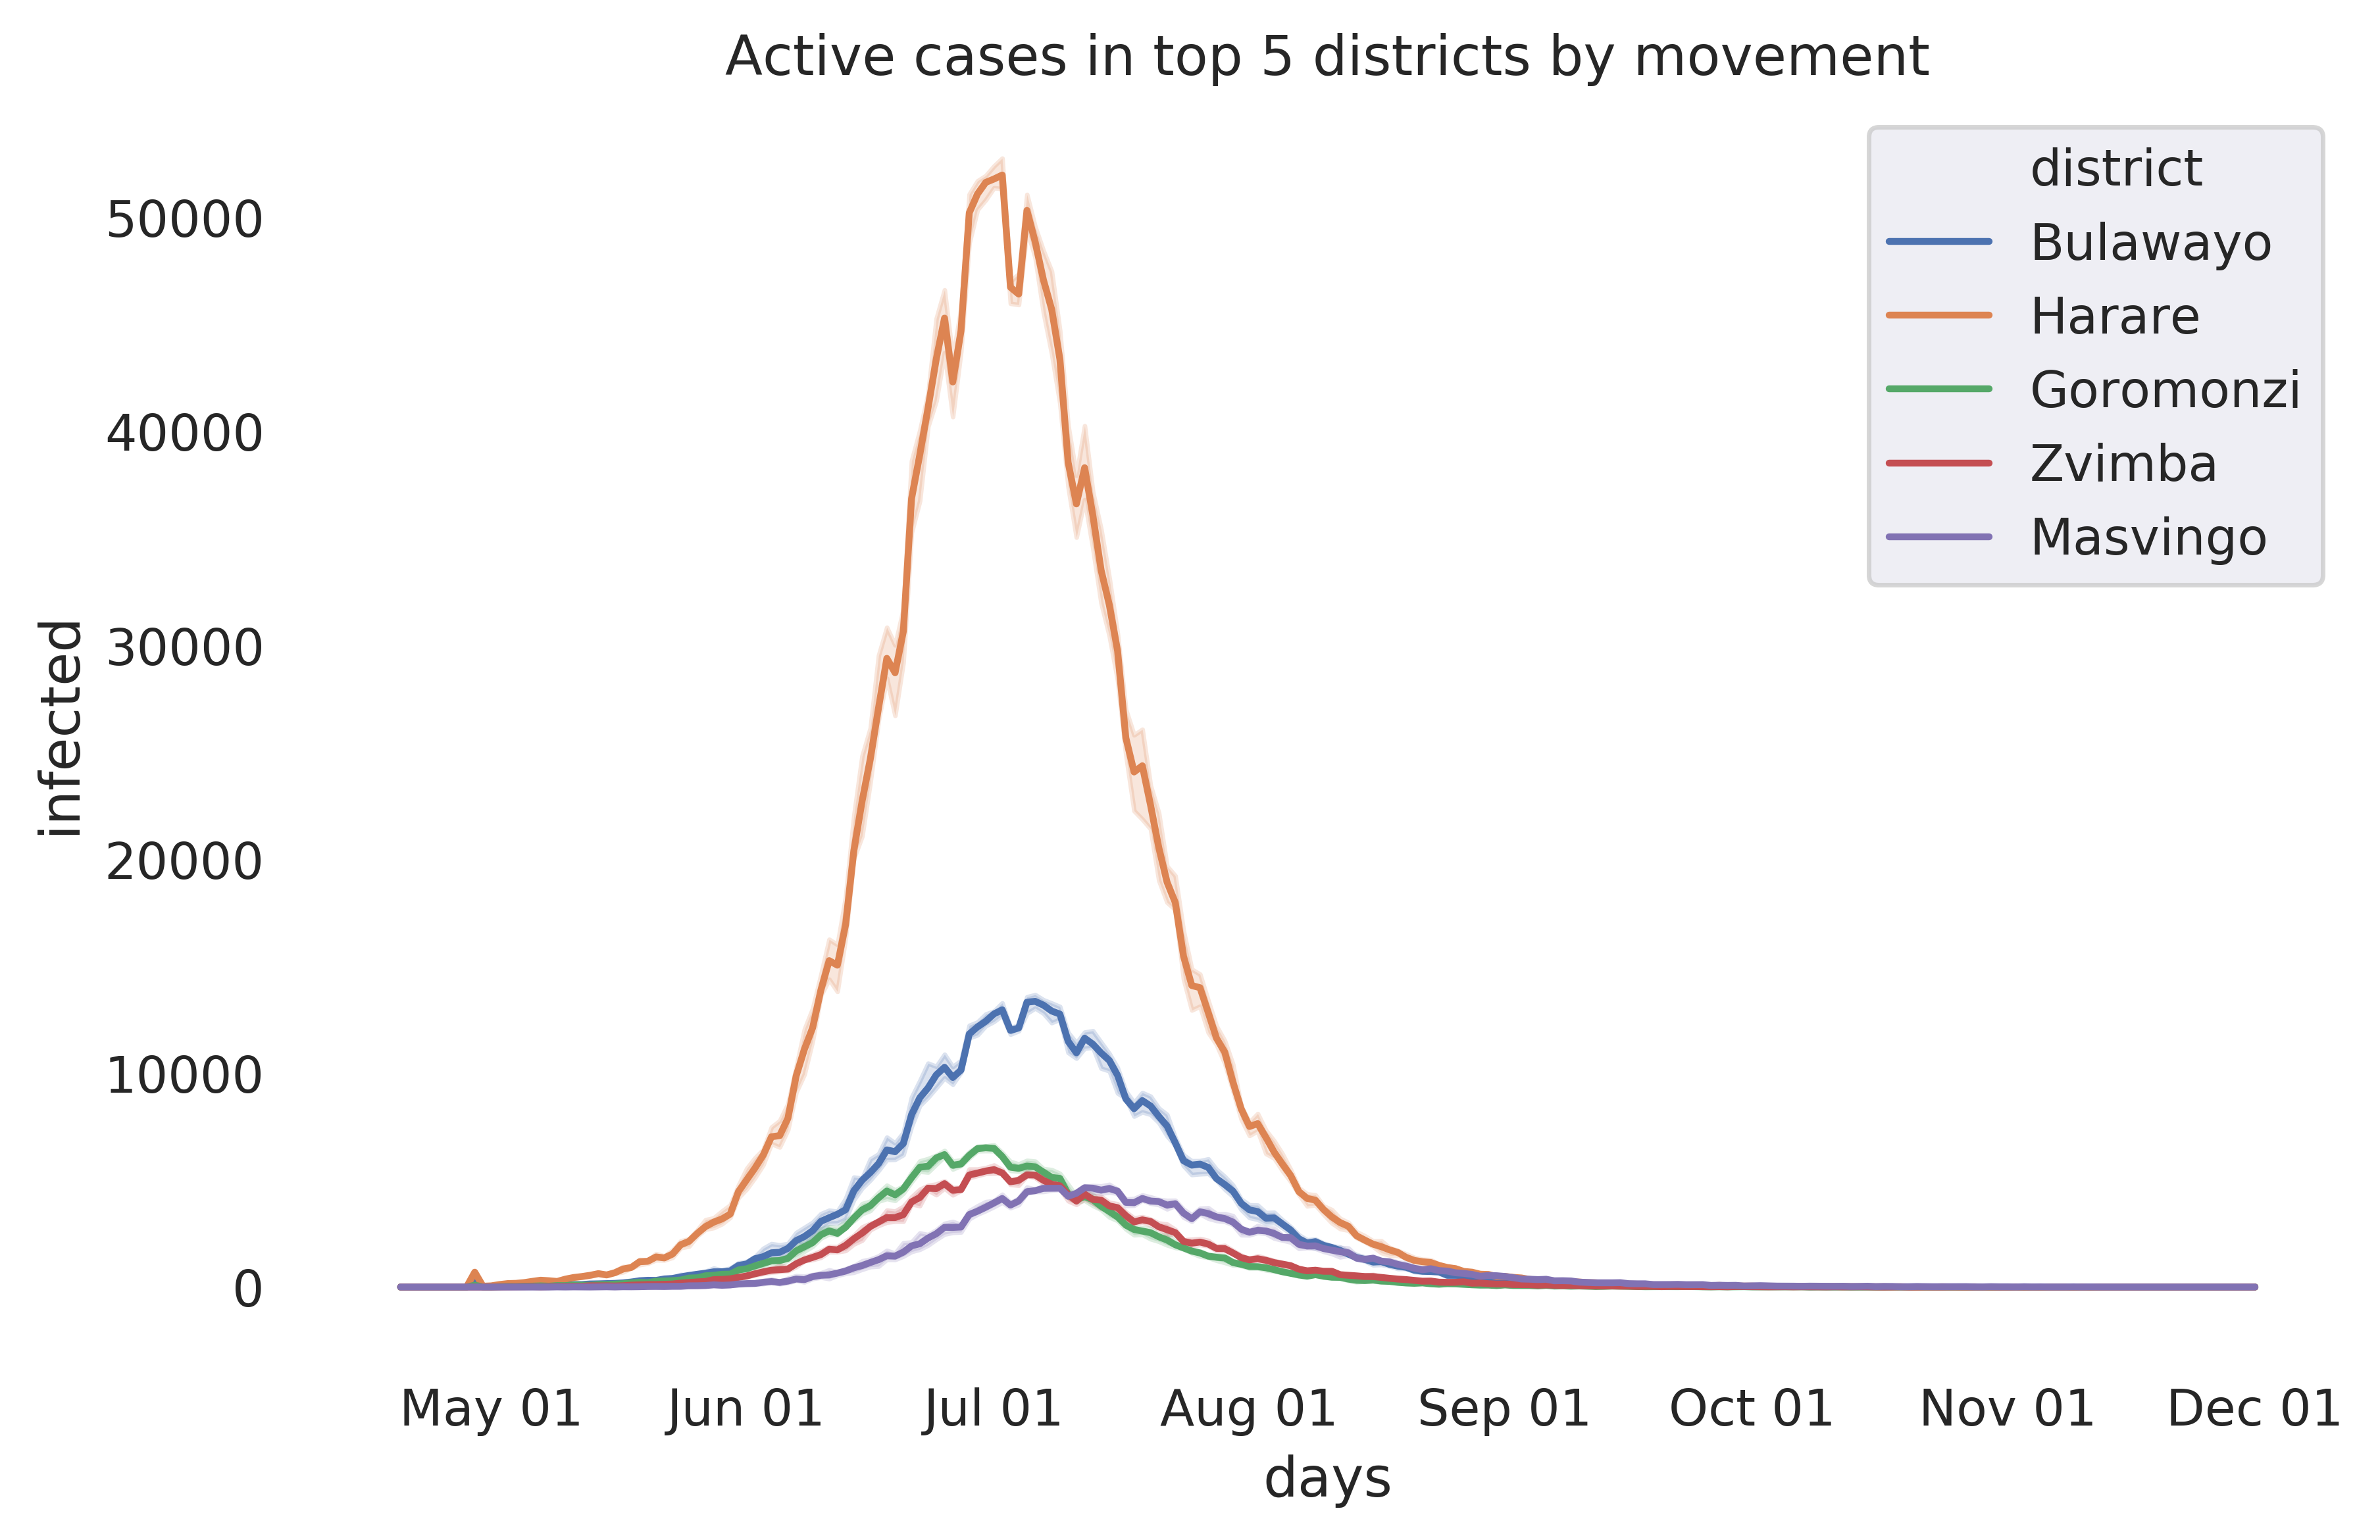

time: 3.51 s


In [53]:
plt.figure(figsize=(8, 5), dpi=500)

ax = sns.lineplot(x=f'{tperiod}s', y="infected", hue='district',
             data=top_5_inbound, n_boot=10)
ax.patch.set_alpha(0)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('Active cases in top 5 districts by movement')

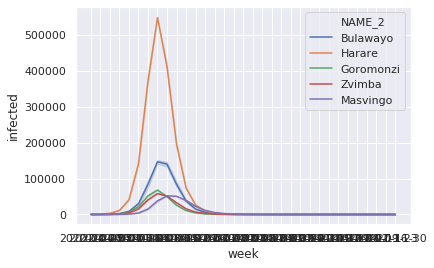

time: 11.3 s


In [23]:
sns.lineplot(x="week", y="infected", hue='NAME_2',
             data=top_5_outbound)

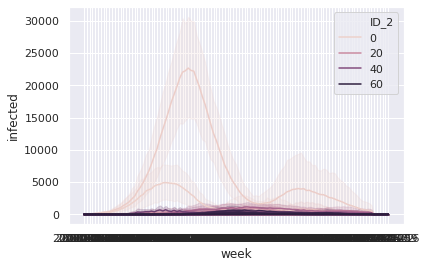

time: 2min 48s


In [24]:
sns.lineplot(x="week", y="infected", hue='ID_2',
             data=scenario_data_df)

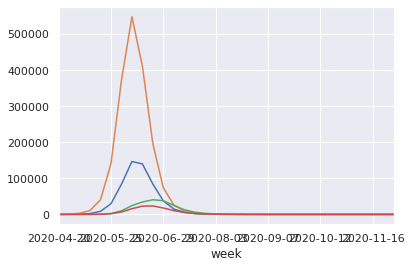

time: 686 ms


In [16]:
ax = scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[1].plot()
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[2].plot(ax=ax)
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[3].plot(ax=ax)
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[4].plot(ax=ax)

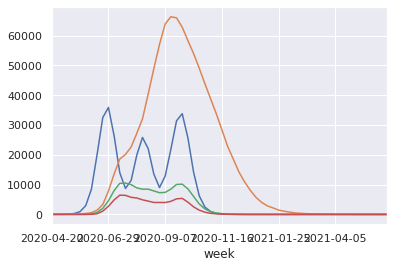

time: 980 ms


In [511]:
ax = scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[1].plot()
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[2].plot(ax=ax)
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[3].plot(ax=ax)
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[4].plot(ax=ax)

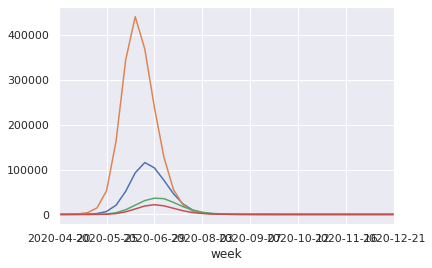

time: 923 ms


In [380]:
ax = scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[1].plot()
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[2].plot(ax=ax)
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[3].plot(ax=ax)
scenario_data_df.groupby(['ID_2', 'week'])['infected'].mean()[4].plot(ax=ax)